In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import wordpunct_tokenize, pos_tag
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
import pickle, string, re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
quora = pd.read_csv("train.csv")
print(quora.shape)
quora.head()

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
quora.isnull().sum(axis=0)  ##finding out NA values

id              0
qid1            0
qid2            0
question1       0
question2       2
is_duplicate    0
dtype: int64

In [4]:
quora.dropna(axis=0, inplace=True) 
#dropping rows which don't have any text, because the data would be useless to us if we can't match it with anything

In [5]:
quora.is_duplicate.mean(axis=0) # proportion of questions matched in the dataset

0.36919967943644133

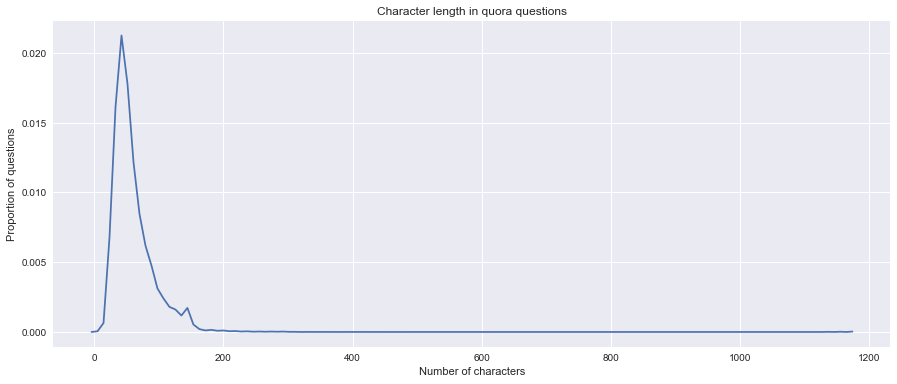

In [9]:
a= quora["question2"].str.len().append(quora["question1"].str.len())
fig, ax= plt.subplots(1,1, figsize= (15,6))
sns.distplot(a, ax=ax, hist=False)
plt.title("Character length in quora questions")
plt.xlabel("Number of characters")
plt.ylabel("Proportion of questions")
'''most of the questions have character length less than ~150?'''

'most of the questions have word length less than ~30'

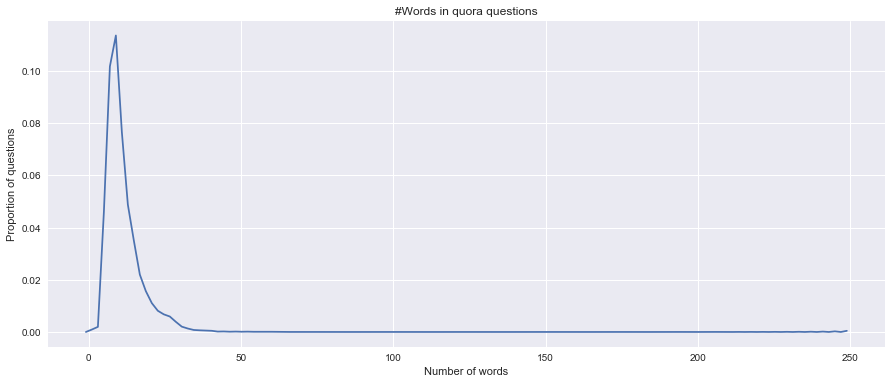

In [13]:
aa= quora.question1.append(quora.question2).apply(lambda row: len([w for w in re.findall(r'\w+', row)]))
fig, ax= plt.subplots(1,1, figsize= (15,6))
sns.distplot(aa, ax=ax, hist=False)
plt.title("#Words in quora questions")
plt.xlabel("Number of words")
plt.ylabel("Proportion of questions")
'''most of the questions have word length less than ~30?'''

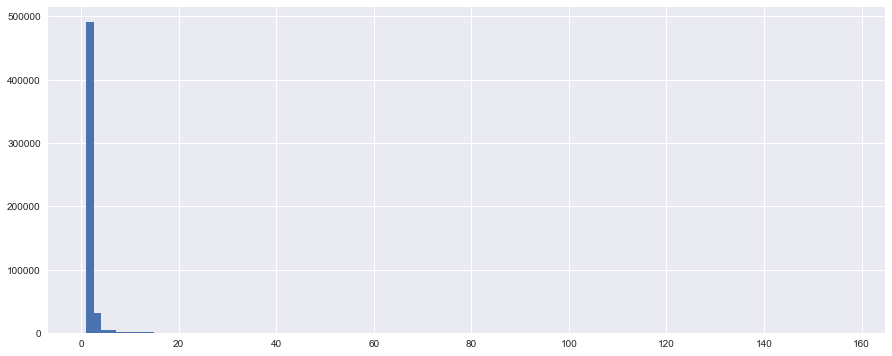

In [15]:
plt.figure(figsize=(15,6))
quora.qid1.append(quora.qid2).value_counts().hist(bins= 100)
'''there many questions which are unique, however some questions are repeated more than once and are matched with some other ques'''

In [16]:
stemmer= PorterStemmer()
def splitQues(ques): 
    '''it takes in a string and will split it on alphanumerical characters. I found it more robust than 
    wordpunct_tokenize from nltk. Additionaly it will stem the tokens into its root and convert it into lower case characters'''
    tokenized= []
    for word in re.findall(r'\w+', ques):
        tokenized.append(stemmer.stem(word.lower()))
    return tokenized

def convert_tag(tag):
    '''the function converts the tags from postag to the tags comprehended by wordnet synsets'''
    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try:
        return tag_dict[tag[0]]
    except KeyError:
        return None

def text_tosynset(text):
    '''the function converts the text to a list of synsets of contained words'''
    text_synsets= []
    for w,tag in pos_tag(wordpunct_tokenize(text)):
        syn= wn.synsets(w.lower(), pos= convert_tag(tag))
        if (convert_tag(tag) is not None) and (len(syn) > 0):
            text_synsets.append(syn[0])
    return text_synsets

def calc_pathsimilarity(text1, text2):
    '''the function looks for each synset in text1 and calcuates path_similarity with all synsets in text2(nltk). 
    It returns the average of maximum computed similarity between synsets in two texts'''
    syn1= text_tosynset(text1)
    syn2= text_tosynset(text2)
    
    similarity_scores=[]
    for s1 in syn1:
        sim_scores_syn= []
        for s2 in syn2:
            syn_score= wn.synset(s1.name()).path_similarity(wn.synset(s2.name()))
            if syn_score is not None:
                sim_scores_syn.append(syn_score)
            
        if len(sim_scores_syn)>0:
            similarity_scores.append(max(sim_scores_syn))
    try:
        return sum(similarity_scores)/len(similarity_scores)
    except:
        return 0
    
def compute_pathsimilarity_score(text1, text2):
    s1= calc_pathsimilarity(text1, text2)
    s2= calc_pathsimilarity(text2, text1)
    
    return (s1+s2)/2


##calculating similarities for words which couldnt be found in wn.synsets
def jaccard_similarity(text1, text2):  #equivalent to jaccard similarity
    '''It calculates jaccard similary between two texts'''
    q1set= set(splitQues(text1))
    q2set= set(splitQues(text2))
    commonwordsN = len(q1set.intersection(q2set))
    try:
        cwr= commonwordsN/len(q1set.union(q2set)) 
    except:
        cwr= 0
    return cwr


def find_weightedSimilarity(row, trained_tfidf):
    ''' it returns similarity of words weighted by tfidf'''
    tfarray= trained_tfidf.transform(row[["question1", "question2"]]).toarray()
    try:
        cs= np.squeeze(cosine_similarity(tfarray[0,:].reshape(1,-1), tfarray[1,:].reshape(1,-1))).item()

    except:
        print(ValueError("couldn't calculate for " + str(row)))
        cs=0
    return cs

In [18]:
'''below commands iterate over each rows and find similarities using above functions'''
quora["path_similarity"] = quora.apply(lambda x: compute_pathsimilarity_score(x["question1"], x["question2"]), axis= 1)
quora["jacc_similarity"] = quora.apply(lambda x: jaccard_similarity(x["question1"], x["question2"]), axis= 1)

In [20]:
'''I have saved everything in a pickle to avoid computing it over and over again'''
# quora.to_pickle('quora.pickle')
quora= pd.read_pickle('quora.pickle') 

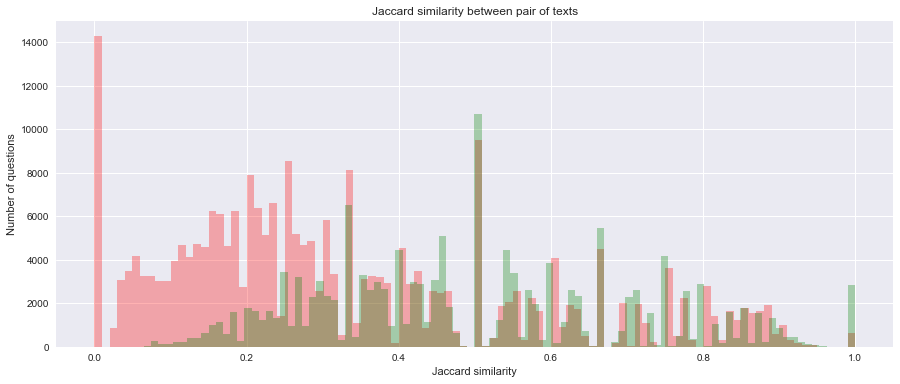

In [21]:
plt.figure(figsize= (15,6))
plt.hist(quora.loc[quora.is_duplicate==0, "jacc_similarity"], bins=100, color="red", alpha= 0.3)
plt.hist(quora.loc[quora.is_duplicate==1, "jacc_similarity"], bins=100, color="green", alpha=0.3)
plt.title('Jaccard similarity between pair of texts')
plt.xlabel('Jaccard similarity')
plt.ylabel('Number of questions')
plt.show()

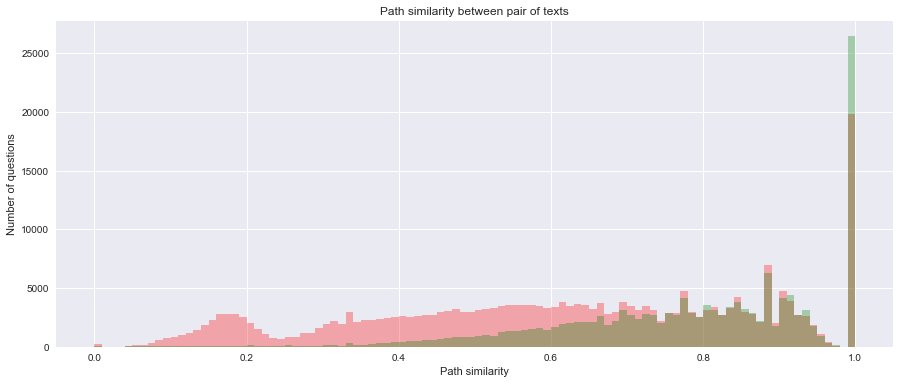

In [22]:
plt.figure(figsize= (15,6))
plt.hist(quora.loc[quora.is_duplicate==0, "path_similarity"], bins=100, color="red", alpha= 0.3)
plt.hist(quora.loc[quora.is_duplicate==1, "path_similarity"], bins=100, color="green", alpha=0.3)
plt.title('Path similarity between pair of texts')
plt.xlabel('Path similarity')
plt.ylabel('Number of questions')
plt.show()
'''Path similarity does better than jaccard similarity in segregating the classes'''

Creating a dictionary of questions to be fed in tfidf, since directly feeding the series of string to compute tfidf could skew the tfidf weigh from questions which are appearing more than once in the dataset

In [26]:
question_mapping= {}
for qid in quora.qid1.append(quora.qid2).unique():   # creating data to compute tfidf by taking only unique texts
    if not qid in question_mapping:
        try: #if qid is found in qid1
            question_mapping[qid]= quora.loc[quora.qid1==qid, "question1"].values[0]
        except:  #or else look for qid in qid2
            question_mapping[qid]= quora.loc[quora.qid2==qid, "question2"].values[0]

f= open("question_mapping_dict.pickle","wb+")  #the above process takes time and hence would be wise to pickle it
pickle.dump(question_mapping, f)
f.close()

In [23]:
question_mapping_Series= pd.Series(question_mapping)  #saving the above dictionary in a pandas series for feeding it into tfidf
tf= TfidfVectorizer(lowercase=True, tokenizer=splitQues)  # I have created my own tokenizer (see functions created above)
X= tf.fit_transform(question_mapping_Series)
tf_pickle= open("tfidf.pickle", "wb+")
pickle.dump(tf, tf_pickle)  #I think i am in love with pickle here

In [24]:
quora["tfidf_similarity"] = quora.apply(lambda x: find_weightedSimilarity(x,tf), axis= 1) 
#it uses a function which computes tfidf of new dataset based on trained tf

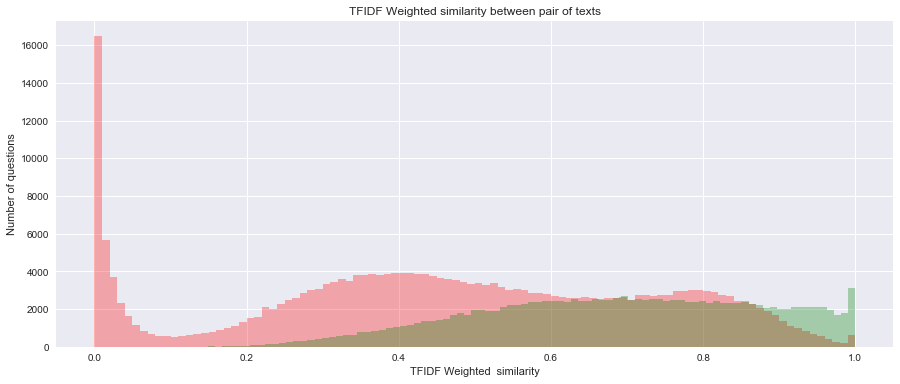

In [26]:
plt.figure(figsize= (15,6))
plt.hist(quora.loc[quora.is_duplicate==0, "tfidf_similarity"], bins=100, color="red", alpha= 0.3)
plt.hist(quora.loc[quora.is_duplicate==1, "tfidf_similarity"], bins=100, color="green", alpha=0.3)
plt.title('TFIDF Weighted similarity between pair of texts')
plt.xlabel('TFIDF Weighted  similarity')
plt.ylabel('Number of questions')
plt.show()

The above two features are observed to be better in separating the two classes compared to making feature using alone common words (Jaccard similarity)

In [27]:
quora.to_pickle('quora.pickle')
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate,path_similarity,jacc_similarity,tfidf_similarity
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.933333,0.916667,0.973957
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.582143,0.411765,0.760246
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.574359,0.263158,0.398740
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.612500,0.000000,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.483320,0.250000,0.268680


In [28]:
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

In [38]:
xtrain, xtest, ytrain, ytest= train_test_split(quora[["path_similarity", "jacc_similarity", "tfidf_similarity"]], quora["is_duplicate"], test_size= 0.7, random_state=4)

lr= LogisticRegression()
lr.fit(xtrain, ytrain)
print("ROC score of test set {}".format(roc_auc_score(ytest, lr.predict_proba(xtest)[:,1])))
print("Log loss value of train set {}".format(log_loss(ytrain, lr.predict_proba(xtrain))))
print("Log loss value of test set {}".format(log_loss(ytest, lr.predict_proba(xtest))))

ROC score of test set 0.743649527708155
Log loss value of train set 0.5605487198187185
Log loss value of test set 0.5620086788585419


In [ ]:
'''Next script will be tuning trees to make a hopefully better model than this'''